In [1]:
import pandas as pd

# Load dataset
df = pd.read_excel('Online Retail.xlsx')

# Check for missing values
df.isnull().sum()

# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)


In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Create Total Price column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [4]:
import datetime as dt

# Assume the current date is one day after the last purchase in the dataset
current_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate Recency
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (current_date - recency['InvoiceDate']).dt.days
recency.drop('InvoiceDate', axis=1, inplace=True)


In [5]:
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']


In [6]:
monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']


In [7]:
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')


In [8]:
# Calculate Average Order Value (AOV)
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Calculate Purchase Frequency
total_orders = df['InvoiceNo'].nunique()
unique_customers = df['CustomerID'].nunique()
purchase_frequency = total_orders / unique_customers

# Assume Customer Lifetime (in days)
customer_lifetime = rfm['Recency'].mean()

# Calculate CLV
rfm['CLV'] = rfm['AOV'] * purchase_frequency * (1 / customer_lifetime)


In [9]:
# Segment customers based on CLV
rfm['CLV_Segment'] = pd.qcut(rfm['CLV'], 3, labels=['Low', 'Medium', 'High'])


C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


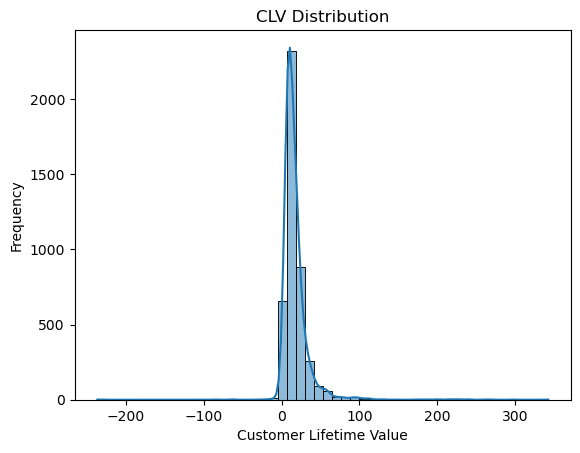

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm['CLV'], bins=50, kde=True)
plt.title('CLV Distribution')
plt.xlabel('Customer Lifetime Value')
plt.ylabel('Frequency')
plt.show()


In [11]:
# Example of additional features
df['FirstPurchase'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')
df['Tenure'] = (df['InvoiceDate'] - df['FirstPurchase']).dt.days
tenure = df.groupby('CustomerID')['Tenure'].max().reset_index()

# Merging with RFM data
rfm = rfm.merge(tenure, on='CustomerID')



In [13]:
# Set a cutoff date to split data into training and future periods
cutoff_date = pd.to_datetime('2024-08-01')


# Calculate future CLV (total future revenue after the cutoff date)
future_df = df[df['InvoiceDate'] > cutoff_date]
future_clv = future_df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
future_clv.columns = ['CustomerID', 'FutureCLV']

# Merge with the RFM dataset
rfm = rfm.merge(future_clv, on='CustomerID', how='left').fillna(0)


TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [ ]:
from sklearn.model_selection import train_test_split

# Define feature columns
feature_cols = ['Recency', 'Frequency', 'Monetary', 'Tenure', 'AOV']  # Add more features as needed

# Define target
X = rfm[feature_cols]
y = rfm['FutureCLV']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model
model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)
